# Study case: MNIST hand-written digits dataset

##### License: Apache 2.0


This notebook shows how to use topological data analysis to generate features for classifying digits.

The first step consists in importing the *giotto* library.

In [2]:
import sys
sys.path.insert(0, './giotto-tda')
from gtda.images import Binarizer, Inverter, HeightFiltration, RadialFiltration
from gtda.homology import VietorisRipsPersistence, CubicalPersistence
from gtda.diagrams import  PairwiseDistance, Amplitude, Scaler, PersistenceEntropy, BettiCurve, PersistenceLandscape, HeatKernel
from BnDs.analysis.utils.ImageToPointCloud import ImageToPointCloud

print('Successfully loaded giotto!')


Successfully loaded giotto!


In [3]:
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion, make_union
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.base import clone


import numpy as np
import pandas as pd
import random
import gzip
import pickle as pkl
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
#%matplotlib inline

## Loading the MNIST dataset

In [4]:
# Read the data
((X, y), (X_valid, y_valid), _) = pkl.load(gzip.open('./data/mnist.pkl.gz', 'rb'), encoding='latin-1')

X = X.reshape(-1, 28, 28)
X = X[:100]
y = y[:100]

print(X.shape, y.shape)
print(np.min(X), np.max(X))

(100, 28, 28) (100,)
0.0 0.99609375


In [5]:
# Set up the data
n_train, n_test = int(X.shape[0] * 0.8), int(X.shape[0] * 0.2)

X_train = X[:n_train]
y_train = y[:n_train]
X_test = X[n_train:n_train+n_test]
y_test = y[n_train:n_train+n_test]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(80, 28, 28) (80,) (20, 28, 28) (20,)


In [6]:
direction_list = [ [1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1] ] 
center_list = [ [13, 6], [6, 13], [13, 13], [20, 13], [13, 20], [6, 6], [6, 20], [20, 6], [20, 20] ]
n_iterations_erosion_list = [6, 10]
n_iterations_dilation_list = [6, 10]
n_iterations_signed_list = [6, 10]
n_neighbors_list = [2, 4]

filtration_list = \
 [HeightFiltration(direction=direction) 
   for direction in direction_list] + \
 [RadialFiltration(center=center) 
   for center in center_list] + \
 [None]

binarizer = Binarizer(threshold=0.4)
point = ImageToPointCloud()
cubical = CubicalPersistence(homology_dimensions=[0, 1])
rips = VietorisRipsPersistence(homology_dimensions=[0, 1])
scaler = Scaler(metric='bottleneck')

grayscale_steps = [[cubical, scaler]]
filtration_steps = [[binarizer, filtration, cubical, scaler] for filtration in filtration_list]
# Point step provokes:
# ValueError: Input contains NaN, infinity or a value too large for dtype('float64').
# Cause: Point gives infinity for all values where there is no point in order to conserve the dimensions of the array
# Temporary solution: remove check_array from VietorisRips function responsible for checking for Inf
rips_steps = [[binarizer, point, rips, scaler]]

image_steps = grayscale_steps + filtration_steps + rips_steps

metric_list = [ 
   {'metric': 'bottleneck', 'metric_params': {'p': np.inf}},
   {'metric': 'wasserstein', 'metric_params': {'p': 1}},
   {'metric': 'wasserstein', 'metric_params': {'p': 2}},
   {'metric': 'landscape', 'metric_params': {'p': 1, 'n_layers': 1, 'n_values': 100}},
   {'metric': 'landscape', 'metric_params': {'p': 1, 'n_layers': 2, 'n_values': 100}},
   {'metric': 'landscape', 'metric_params': {'p': 2, 'n_layers': 1, 'n_values': 100}},
   {'metric': 'landscape', 'metric_params': {'p': 2, 'n_layers': 2, 'n_values': 100}},
   {'metric': 'betti', 'metric_params': {'p': 1, 'n_values': 100}},
   {'metric': 'betti', 'metric_params': {'p': 2, 'n_values': 100}},
   {'metric': 'heat', 'metric_params': {'p': 1, 'sigma': 1.6, 'n_values': 100}},
   {'metric': 'heat', 'metric_params': {'p': 1, 'sigma': 3.2, 'n_values': 100}},
   {'metric': 'heat', 'metric_params': {'p': 2, 'sigma': 1.6, 'n_values': 100}},
   {'metric': 'heat', 'metric_params': {'p': 2, 'sigma': 3.2, 'n_values': 100}}
]

entropy_steps = [steps + [PersistenceEntropy()] for steps in image_steps]
amplitude_steps = [steps+[Amplitude(**metric, order=None)] for steps in image_steps for metric in metric_list]

all_steps = entropy_steps + amplitude_steps
feature_union = make_union(*[make_pipeline(*steps) for steps in all_steps], n_jobs=-1)

In [9]:
feature_union.get_feature_names()

AttributeError: Transformer pipeline-1 (type Pipeline) does not provide get_feature_names.

In [122]:
x_point_test = point.fit_transform(X_train, y_train)
#print(np.isnan(x_point_test).any())
#print(np.isinf(x_point_test).any())
print(np.sum(X_train))
x_point_test


7813.0117


array([[[inf, inf],
        [inf, inf],
        [inf, inf],
        ...,
        [inf, inf],
        [inf, inf],
        [inf, inf]],

       [[inf, inf],
        [inf, inf],
        [inf, inf],
        ...,
        [inf, inf],
        [inf, inf],
        [inf, inf]],

       [[inf, inf],
        [inf, inf],
        [inf, inf],
        ...,
        [inf, inf],
        [inf, inf],
        [inf, inf]],

       ...,

       [[inf, inf],
        [inf, inf],
        [inf, inf],
        ...,
        [inf, inf],
        [inf, inf],
        [inf, inf]],

       [[inf, inf],
        [inf, inf],
        [inf, inf],
        ...,
        [inf, inf],
        [inf, inf],
        [inf, inf]],

       [[inf, inf],
        [inf, inf],
        [inf, inf],
        ...,
        [inf, inf],
        [inf, inf],
        [inf, inf]]])

In [124]:
X_train_tda = feature_union.fit_transform(X_train, y_train)
pkl.dump(X_train_tda, open('X_train_tda.pkl', 'wb'))

In [125]:
X_test_tda = feature_union.transform(X_test)
pkl.dump(X_test_tda, open('X_test_tda.pkl', 'wb'))

In [126]:
print(X_train_tda.shape)

(80, 560)


In [127]:
classifier = RandomForestClassifier(n_estimators=10000, n_jobs=-1)
classifier.fit(X_train_tda, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [128]:
y_train_predict = classifier.predict(X_train_tda)
pkl.dump(y_train_predict, open('y_train_predict_tda.pkl', 'wb'))

In [129]:
y_test_predict = classifier.predict(X_test_tda)
pkl.dump(y_test_predict, open('y_test_predict_tda.pkl', 'wb'))

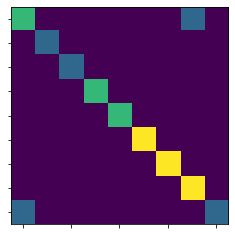

In [130]:
confusion = confusion_matrix(y_test, y_test_predict)
plt.imshow(confusion)
plt.show()

In [131]:
importance = -classifier.feature_importances_
importance_indices = np.argsort(importance)

In [138]:
X_train_importance = X_train_tda[:, importance_indices]
print(X_train_importance.shape)

(80, 560)


/Users/julian/.conda/envs/BnDs/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: divide by zero encountered in true_divide
  c /= stddev[:, None]
/Users/julian/.conda/envs/BnDs/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/julian/.conda/envs/BnDs/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: divide by zero encountered in true_divide
  c /= stddev[None, :]
/Users/julian/.conda/envs/BnDs/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


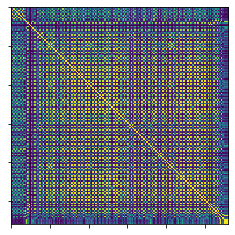

In [133]:
correlation = np.abs(np.corrcoef(X_train_tda.T))
plt.imshow(correlation)
plt.show()

In [134]:
def select_features(correlation_, importance_indices_, threshold_):
    decorrelated_index = importance_indices_[:1]

    for index in importance_indices_[1:]:
        if np.sum(correlation_[decorrelated_index, index] > threshold_) == 0:
            decorrelated_index = np.append(decorrelated_index, [index])
    return decorrelated_index

In [135]:
def run_cv_scores(thresholds_list_, n_features_list_, correlation_, importance_indices_, postfix, n_folds=3):
    for threshold_ in thresholds_list_:
        print('threshold: ', threshold_)
        decorrelated_feature_index = select_features(correlation_, importance_indices_, threshold_=threshold_)
        n_features_max = decorrelated_feature_index.shape[0]
        print('Number of decorrelated features: ', n_features_max)
        n_features_list = sorted(list(set([n_features if n_features <= n_features_max else n_features_max
                               for n_features in n_features_list_])))
        print('n_features_list: ', n_features_list)

        cv_scores = {}
        cv = KFold(n_folds)
        for n_features in n_features_list:
            X_train_n_features = X_train_tda[:, decorrelated_feature_index[:n_features]]
            print('X_train shape: ', X_train_n_features.shape)
            cv_scores[n_features] = cross_val_score(classifier, 
                                                    X_train_n_features, 
                                                    y_train, cv=cv)
            print('cv scores for', postfix, ': ', n_features, cv_scores[n_features])
        pkl.dump(cv_scores, open('cv_scores_'+str(threshold_)+'_'+postfix+'.pkl', 'wb'))

In [136]:
thresholds_list = [0.8, 0.9, 0.95, 1.0]
n_features_list = [4, 8, 28, 42, 56, 112, 178, 244, 392, 784]
run_cv_scores(thresholds_list, n_features_list, correlation, importance_indices, 'tda')

threshold:  0.8
Number of decorrelated features:  63
n_features_list:  [4, 8, 28, 42, 56, 63]
X_train shape:  (80, 4)


/Users/julian/.conda/envs/BnDs/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


cv scores for tda :  4 [0.66666667 0.48148148 0.80769231]
X_train shape:  (80, 8)
cv scores for tda :  8 [0.77777778 0.62962963 0.73076923]
X_train shape:  (80, 28)
cv scores for tda :  28 [0.85185185 0.66666667 0.84615385]
X_train shape:  (80, 42)
cv scores for tda :  42 [0.81481481 0.7037037  0.88461538]
X_train shape:  (80, 56)
cv scores for tda :  56 [0.81481481 0.7037037  0.88461538]
X_train shape:  (80, 63)
cv scores for tda :  63 [0.81481481 0.7037037  0.88461538]
threshold:  0.9
Number of decorrelated features:  91
n_features_list:  [4, 8, 28, 42, 56, 91]
X_train shape:  (80, 4)


/Users/julian/.conda/envs/BnDs/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


cv scores for tda :  4 [0.59259259 0.48148148 0.57692308]
X_train shape:  (80, 8)
cv scores for tda :  8 [0.81481481 0.7037037  0.73076923]
X_train shape:  (80, 28)
cv scores for tda :  28 [0.85185185 0.7037037  0.92307692]
X_train shape:  (80, 42)
cv scores for tda :  42 [0.85185185 0.66666667 0.88461538]
X_train shape:  (80, 56)
cv scores for tda :  56 [0.85185185 0.7037037  0.88461538]
X_train shape:  (80, 91)
cv scores for tda :  91 [0.85185185 0.7037037  0.88461538]
threshold:  0.95
Number of decorrelated features:  136
n_features_list:  [4, 8, 28, 42, 56, 112, 136]
X_train shape:  (80, 4)


/Users/julian/.conda/envs/BnDs/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


cv scores for tda :  4 [0.59259259 0.51851852 0.65384615]
X_train shape:  (80, 8)
cv scores for tda :  8 [0.62962963 0.59259259 0.76923077]
X_train shape:  (80, 28)
cv scores for tda :  28 [0.85185185 0.66666667 0.88461538]
X_train shape:  (80, 42)
cv scores for tda :  42 [0.85185185 0.66666667 0.88461538]
X_train shape:  (80, 56)
cv scores for tda :  56 [0.85185185 0.66666667 0.84615385]
X_train shape:  (80, 112)
cv scores for tda :  112 [0.81481481 0.7037037  0.80769231]
X_train shape:  (80, 136)
cv scores for tda :  136 [0.81481481 0.7037037  0.80769231]
threshold:  1.0
Number of decorrelated features:  560
n_features_list:  [4, 8, 28, 42, 56, 112, 178, 244, 392, 560]
X_train shape:  (80, 4)


/Users/julian/.conda/envs/BnDs/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


cv scores for tda :  4 [0.59259259 0.51851852 0.65384615]
X_train shape:  (80, 8)
cv scores for tda :  8 [0.59259259 0.51851852 0.65384615]
X_train shape:  (80, 28)
cv scores for tda :  28 [0.81481481 0.55555556 0.80769231]
X_train shape:  (80, 42)
cv scores for tda :  42 [0.85185185 0.66666667 0.80769231]
X_train shape:  (80, 56)
cv scores for tda :  56 [0.85185185 0.62962963 0.84615385]
X_train shape:  (80, 112)
cv scores for tda :  112 [0.85185185 0.62962963 0.92307692]
X_train shape:  (80, 178)
cv scores for tda :  178 [0.85185185 0.62962963 0.84615385]
X_train shape:  (80, 244)
cv scores for tda :  244 [0.85185185 0.66666667 0.80769231]
X_train shape:  (80, 392)
cv scores for tda :  392 [0.81481481 0.74074074 0.80769231]
X_train shape:  (80, 560)
cv scores for tda :  560 [0.81481481 0.74074074 0.80769231]
